In [78]:
import os
import json
import torch
from torch_geometric.data import Dataset, Data

class SingleFileEmbeddingPairDataset(Dataset):
    def __init__(self, json_path):
        super().__init__(os.path.dirname(json_path))
        # Load the JSON (which is a dict of model numbers)
        with open(json_path, 'r') as f:
            model_dict = json.load(f)
            # Flatten all model pairs into a list:
            self.all_pairs = []
            for model_num, pair in model_dict.items():
                # Optionally store model_num if you want it later: pair['model_num'] = model_num
                self.all_pairs.append(pair)

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):
        pair = self.all_pairs[idx]

        # Extract embeddings for A and B
        A_ids = sorted(pair['A_embeddings'].keys(), key=lambda x: int(x))
        xA = torch.tensor([pair['A_embeddings'][xtid] for xtid in A_ids], dtype=torch.float)
        B_ids = sorted(pair['B_embeddings'].keys(), key=lambda x: int(x))
        xB = torch.tensor([pair['B_embeddings'][xtid] for xtid in B_ids], dtype=torch.float)

        # Dummy edge indices (empty for now)
        edge_indexA = torch.empty((2,0), dtype=torch.long)
        edge_indexB = torch.empty((2,0), dtype=torch.long)

        A_id_to_idx = {int(aid): idx for idx, aid in enumerate(A_ids)}
        B_id_to_idx = {int(bid): idx for idx, bid in enumerate(B_ids)}

        mappings = []
        for a, b in pair['mappings']:
            idx_a = -1 if a == 'NULL' else A_id_to_idx[int(a)]  
            idx_b = -1 if b == 'NULL' else B_id_to_idx[int(b)]
            mappings.append([idx_a, idx_b])

        matches = torch.tensor(mappings, dtype=torch.long)

        dataA = Data(x=xA, edge_index=edge_indexA, xt_entity_ids=A_ids)
        dataB = Data(x=xB, edge_index=edge_indexB, xt_entity_ids=B_ids)
        return dataA, dataB, matches

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv

class GraphEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, out_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x


class SiameseGNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, proj_dim=None, dropout=0.3):
        super().__init__()
        self.encoder = GraphEncoder(in_dim, hidden_dim, out_dim, dropout)
        
        # Optional projection MLP for better embedding alignment
        if proj_dim is not None:
            self.projector = nn.Sequential(
                nn.Linear(out_dim, proj_dim),
                nn.BatchNorm1d(proj_dim),
                nn.ReLU(),
                nn.Linear(proj_dim, proj_dim)
            )
            self.final_dim = proj_dim
        else:
            self.projector = None
            self.final_dim = out_dim

    def forward(self, data1, data2):
        h1 = self.encoder(data1.x, data1.edge_index)
        h2 = self.encoder(data2.x, data2.edge_index)

        if self.projector is not None:
            h1 = self.projector(h1)
            h2 = self.projector(h2)

        # Normalize embeddings for contrastive or cosine losses
        # h1 = F.normalize(h1, p=2, dim=-1)
        # h2 = F.normalize(h2, p=2, dim=-1)
        return h1, h2


In [ ]:
import torch
import torch.nn.functional as F

def triplet_loss(emb1, emb2, matches, margin=1.0, num_neg=5):
    # emb1: [N1, D]; emb2: [N2, D]
    # matches: [K, 2] -> positive indices (A_i, B_i)
    emb1 = F.normalize(emb1, p=2, dim=1)
    emb2 = F.normalize(emb2, p=2, dim=1)

    pos1 = emb1[matches[:, 0]]
    pos2 = emb2[matches[:, 1]]

    # Compute distances for positives
    pos_dist = (pos1 - pos2).pow(2).sum(dim=1)

    # Sample negatives from emb2 (mismatched faces)
    neg_indices = torch.randint(0, emb2.size(0), (len(matches), num_neg), device=emb1.device)
    neg_samples = emb2[neg_indices]  # [K, num_neg, D]

    # Compute negative distances
    neg_dists = ((pos1.unsqueeze(1) - neg_samples)**2).sum(dim=2)  # [K, num_neg]

    # Use hardest negative (max violation)
    hardest_neg = neg_dists.min(dim=1)[0]

    loss = F.relu(pos_dist - hardest_neg + margin).mean()
    return loss


In [82]:
def batch_accuracy(emb1, emb2, matches):
    # emb1: [N1, D], emb2: [N2, D], matches: [K,2]
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None  # avoid NaN

    dists = torch.cdist(emb1, emb2)  # [N1, N2]
    # For each ground-truth emb1 index, which emb2 is closest
    min_indices = torch.argmin(dists[indices1], dim=1)
    correct = (min_indices == indices2).float()
    return correct.mean().item()

In [81]:
def batch_topk_accuracy(emb1, emb2, matches, k=5):
    valid = matches[:,1] != -1
    indices1 = matches[valid, 0]
    indices2 = matches[valid, 1]

    if len(indices1) == 0:
        return None

    dists = torch.cdist(emb1, emb2)

    actual_k = min(k, emb2.shape[0])
    if actual_k == 0:
        return None  # no candidates

    topk = torch.topk(-dists[indices1], actual_k, dim=1).indices
    correct = torch.any(topk == indices2.unsqueeze(1), dim=1).float()
    return correct.mean().item()

Found 134 dataset entries.
Using device: cpu


Epoch 1: 100%|██████████| 134/134 [00:00<00:00, 164.26it/s]


Epoch 001: Loss = 1.2596, Top-1 = 9.61%, Top-5 = 38.58%


Epoch 2: 100%|██████████| 134/134 [00:00<00:00, 168.77it/s]


Epoch 002: Loss = 1.1483, Top-1 = 9.29%, Top-5 = 39.96%


Epoch 3: 100%|██████████| 134/134 [00:00<00:00, 183.00it/s]


Epoch 003: Loss = 1.0786, Top-1 = 10.54%, Top-5 = 41.02%


Epoch 4: 100%|██████████| 134/134 [00:00<00:00, 188.79it/s]


Epoch 004: Loss = 1.0478, Top-1 = 10.27%, Top-5 = 40.37%


Epoch 5: 100%|██████████| 134/134 [00:00<00:00, 176.95it/s]


Epoch 005: Loss = 1.0335, Top-1 = 10.14%, Top-5 = 40.44%


Epoch 6: 100%|██████████| 134/134 [00:00<00:00, 180.29it/s]


Epoch 006: Loss = 1.0235, Top-1 = 10.21%, Top-5 = 41.18%


Epoch 7: 100%|██████████| 134/134 [00:00<00:00, 156.03it/s]


Epoch 007: Loss = 1.0188, Top-1 = 10.63%, Top-5 = 40.47%


Epoch 8: 100%|██████████| 134/134 [00:00<00:00, 162.17it/s]


Epoch 008: Loss = 1.0157, Top-1 = 10.45%, Top-5 = 40.96%


Epoch 9: 100%|██████████| 134/134 [00:00<00:00, 180.28it/s]


Epoch 009: Loss = 1.0128, Top-1 = 10.97%, Top-5 = 40.66%


Epoch 10: 100%|██████████| 134/134 [00:00<00:00, 179.68it/s]


Epoch 010: Loss = 1.0120, Top-1 = 9.47%, Top-5 = 40.90%


Epoch 11: 100%|██████████| 134/134 [00:00<00:00, 181.13it/s]


Epoch 011: Loss = 1.0101, Top-1 = 11.59%, Top-5 = 40.96%


Epoch 12: 100%|██████████| 134/134 [00:00<00:00, 183.75it/s]


Epoch 012: Loss = 1.0091, Top-1 = 10.25%, Top-5 = 40.18%


Epoch 13: 100%|██████████| 134/134 [00:00<00:00, 183.37it/s]


Epoch 013: Loss = 1.0082, Top-1 = 9.49%, Top-5 = 40.60%


Epoch 14: 100%|██████████| 134/134 [00:00<00:00, 180.90it/s]


Epoch 014: Loss = 1.0077, Top-1 = 10.33%, Top-5 = 42.37%


Epoch 15: 100%|██████████| 134/134 [00:00<00:00, 170.21it/s]


Epoch 015: Loss = 1.0068, Top-1 = 9.94%, Top-5 = 40.74%


Epoch 16: 100%|██████████| 134/134 [00:00<00:00, 153.52it/s]


Epoch 016: Loss = 1.0059, Top-1 = 10.60%, Top-5 = 40.27%


Epoch 17: 100%|██████████| 134/134 [00:00<00:00, 163.85it/s]


Epoch 017: Loss = 1.0055, Top-1 = 11.13%, Top-5 = 41.71%


Epoch 18: 100%|██████████| 134/134 [00:00<00:00, 171.08it/s]


Epoch 018: Loss = 1.0049, Top-1 = 11.07%, Top-5 = 42.01%


Epoch 19: 100%|██████████| 134/134 [00:00<00:00, 158.34it/s]


Epoch 019: Loss = 1.0046, Top-1 = 10.16%, Top-5 = 41.32%


Epoch 20: 100%|██████████| 134/134 [00:00<00:00, 178.12it/s]


Epoch 020: Loss = 1.0044, Top-1 = 10.61%, Top-5 = 40.93%


Epoch 21: 100%|██████████| 134/134 [00:00<00:00, 162.16it/s]


Epoch 021: Loss = 1.0038, Top-1 = 11.00%, Top-5 = 41.65%


Epoch 22: 100%|██████████| 134/134 [00:00<00:00, 162.85it/s]


Epoch 022: Loss = 1.0036, Top-1 = 10.27%, Top-5 = 40.86%


Epoch 23: 100%|██████████| 134/134 [00:00<00:00, 154.40it/s]


Epoch 023: Loss = 1.0033, Top-1 = 11.15%, Top-5 = 41.53%


Epoch 24: 100%|██████████| 134/134 [00:00<00:00, 155.75it/s]


Epoch 024: Loss = 1.0030, Top-1 = 9.06%, Top-5 = 40.70%


Epoch 25: 100%|██████████| 134/134 [00:00<00:00, 140.92it/s]


Epoch 025: Loss = 1.0029, Top-1 = 10.37%, Top-5 = 41.56%


Epoch 26: 100%|██████████| 134/134 [00:00<00:00, 160.80it/s]


Epoch 026: Loss = 1.0027, Top-1 = 10.07%, Top-5 = 41.33%


Epoch 27: 100%|██████████| 134/134 [00:00<00:00, 166.71it/s]


Epoch 027: Loss = 1.0027, Top-1 = 10.38%, Top-5 = 41.51%


Epoch 28: 100%|██████████| 134/134 [00:00<00:00, 181.37it/s]


Epoch 028: Loss = 1.0024, Top-1 = 10.33%, Top-5 = 40.37%


Epoch 29: 100%|██████████| 134/134 [00:00<00:00, 184.26it/s]


Epoch 029: Loss = 1.0022, Top-1 = 11.05%, Top-5 = 42.40%


Epoch 30: 100%|██████████| 134/134 [00:00<00:00, 181.01it/s]


Epoch 030: Loss = 1.0020, Top-1 = 10.66%, Top-5 = 42.65%


Epoch 31: 100%|██████████| 134/134 [00:00<00:00, 182.49it/s]


Epoch 031: Loss = 1.0020, Top-1 = 9.94%, Top-5 = 40.09%


Epoch 32: 100%|██████████| 134/134 [00:00<00:00, 189.33it/s]


Epoch 032: Loss = 1.0018, Top-1 = 10.19%, Top-5 = 41.35%


Epoch 33: 100%|██████████| 134/134 [00:00<00:00, 183.75it/s]


Epoch 033: Loss = 1.0017, Top-1 = 11.63%, Top-5 = 41.78%


Epoch 34: 100%|██████████| 134/134 [00:00<00:00, 177.54it/s]


Epoch 034: Loss = 1.0016, Top-1 = 10.58%, Top-5 = 40.94%


Epoch 35: 100%|██████████| 134/134 [00:00<00:00, 187.48it/s]


Epoch 035: Loss = 1.0015, Top-1 = 11.05%, Top-5 = 40.95%


Epoch 36: 100%|██████████| 134/134 [00:00<00:00, 178.13it/s]


Epoch 036: Loss = 1.0014, Top-1 = 10.15%, Top-5 = 41.11%


Epoch 37: 100%|██████████| 134/134 [00:00<00:00, 149.58it/s]


Epoch 037: Loss = 1.0014, Top-1 = 9.06%, Top-5 = 40.23%


Epoch 38: 100%|██████████| 134/134 [00:00<00:00, 186.83it/s]


Epoch 038: Loss = 1.0012, Top-1 = 11.15%, Top-5 = 41.11%


Epoch 39: 100%|██████████| 134/134 [00:00<00:00, 185.92it/s]


Epoch 039: Loss = 1.0012, Top-1 = 11.47%, Top-5 = 40.84%


Epoch 40: 100%|██████████| 134/134 [00:00<00:00, 185.65it/s]


Epoch 040: Loss = 1.0010, Top-1 = 11.33%, Top-5 = 41.04%


Epoch 41: 100%|██████████| 134/134 [00:00<00:00, 180.52it/s]


Epoch 041: Loss = 1.0010, Top-1 = 9.89%, Top-5 = 41.17%


Epoch 42: 100%|██████████| 134/134 [00:00<00:00, 186.40it/s]


Epoch 042: Loss = 1.0010, Top-1 = 10.45%, Top-5 = 42.10%


Epoch 43: 100%|██████████| 134/134 [00:00<00:00, 186.52it/s]


Epoch 043: Loss = 1.0009, Top-1 = 11.32%, Top-5 = 40.83%


Epoch 44: 100%|██████████| 134/134 [00:00<00:00, 180.53it/s]


Epoch 044: Loss = 1.0008, Top-1 = 11.36%, Top-5 = 42.47%


Epoch 45: 100%|██████████| 134/134 [00:00<00:00, 186.70it/s]


Epoch 045: Loss = 1.0008, Top-1 = 11.50%, Top-5 = 42.52%


Epoch 46: 100%|██████████| 134/134 [00:00<00:00, 186.03it/s]


Epoch 046: Loss = 1.0007, Top-1 = 10.23%, Top-5 = 42.73%


Epoch 47: 100%|██████████| 134/134 [00:00<00:00, 185.66it/s]


Epoch 047: Loss = 1.0007, Top-1 = 11.69%, Top-5 = 41.58%


Epoch 48: 100%|██████████| 134/134 [00:00<00:00, 185.14it/s]


Epoch 048: Loss = 1.0006, Top-1 = 10.81%, Top-5 = 42.28%


Epoch 49: 100%|██████████| 134/134 [00:00<00:00, 162.27it/s]


Epoch 049: Loss = 1.0006, Top-1 = 11.34%, Top-5 = 42.20%


Epoch 50: 100%|██████████| 134/134 [00:00<00:00, 186.17it/s]


Epoch 050: Loss = 1.0006, Top-1 = 11.41%, Top-5 = 41.57%


Epoch 51: 100%|██████████| 134/134 [00:00<00:00, 171.95it/s]


Epoch 051: Loss = 1.0005, Top-1 = 10.80%, Top-5 = 41.30%


Epoch 52: 100%|██████████| 134/134 [00:00<00:00, 178.25it/s]


Epoch 052: Loss = 1.0005, Top-1 = 9.46%, Top-5 = 40.12%


Epoch 53: 100%|██████████| 134/134 [00:00<00:00, 183.62it/s]


Epoch 053: Loss = 1.0005, Top-1 = 10.79%, Top-5 = 41.46%


Epoch 54: 100%|██████████| 134/134 [00:00<00:00, 173.51it/s]


Epoch 054: Loss = 1.0005, Top-1 = 10.82%, Top-5 = 40.95%


Epoch 55: 100%|██████████| 134/134 [00:00<00:00, 180.29it/s]


Epoch 055: Loss = 1.0004, Top-1 = 11.65%, Top-5 = 40.43%


Epoch 56: 100%|██████████| 134/134 [00:00<00:00, 177.77it/s]


Epoch 056: Loss = 1.0004, Top-1 = 9.69%, Top-5 = 41.53%


Epoch 57: 100%|██████████| 134/134 [00:00<00:00, 178.60it/s]


Epoch 057: Loss = 1.0004, Top-1 = 10.72%, Top-5 = 41.33%


Epoch 58: 100%|██████████| 134/134 [00:00<00:00, 172.84it/s]


Epoch 058: Loss = 1.0004, Top-1 = 10.71%, Top-5 = 41.90%


Epoch 59: 100%|██████████| 134/134 [00:00<00:00, 177.66it/s]


Epoch 059: Loss = 1.0003, Top-1 = 11.64%, Top-5 = 42.87%


Epoch 60: 100%|██████████| 134/134 [00:00<00:00, 178.13it/s]


Epoch 060: Loss = 1.0003, Top-1 = 11.30%, Top-5 = 42.36%


Epoch 61: 100%|██████████| 134/134 [00:00<00:00, 158.14it/s]


Epoch 061: Loss = 1.0003, Top-1 = 10.60%, Top-5 = 42.14%


Epoch 62: 100%|██████████| 134/134 [00:00<00:00, 183.36it/s]


Epoch 062: Loss = 1.0003, Top-1 = 10.95%, Top-5 = 42.84%


Epoch 63: 100%|██████████| 134/134 [00:00<00:00, 183.74it/s]


Epoch 063: Loss = 1.0003, Top-1 = 11.63%, Top-5 = 42.25%


Epoch 64: 100%|██████████| 134/134 [00:00<00:00, 186.85it/s]


Epoch 064: Loss = 1.0002, Top-1 = 11.05%, Top-5 = 42.92%


Epoch 65: 100%|██████████| 134/134 [00:00<00:00, 185.06it/s]


Epoch 065: Loss = 1.0002, Top-1 = 11.64%, Top-5 = 41.47%


Epoch 66: 100%|██████████| 134/134 [00:00<00:00, 181.01it/s]


Epoch 066: Loss = 1.0002, Top-1 = 11.72%, Top-5 = 41.16%


Epoch 67: 100%|██████████| 134/134 [00:00<00:00, 188.67it/s]


Epoch 067: Loss = 1.0002, Top-1 = 11.38%, Top-5 = 42.66%


Epoch 68: 100%|██████████| 134/134 [00:00<00:00, 187.61it/s]


Epoch 068: Loss = 1.0002, Top-1 = 10.32%, Top-5 = 42.86%


Epoch 69: 100%|██████████| 134/134 [00:00<00:00, 183.12it/s]


Epoch 069: Loss = 1.0002, Top-1 = 11.15%, Top-5 = 41.80%


Epoch 70: 100%|██████████| 134/134 [00:00<00:00, 179.92it/s]


Epoch 070: Loss = 1.0002, Top-1 = 11.18%, Top-5 = 41.53%


Epoch 71: 100%|██████████| 134/134 [00:00<00:00, 177.89it/s]


Epoch 071: Loss = 1.0001, Top-1 = 11.27%, Top-5 = 42.24%


Epoch 72: 100%|██████████| 134/134 [00:00<00:00, 178.25it/s]


Epoch 072: Loss = 1.0001, Top-1 = 11.33%, Top-5 = 42.52%


Epoch 73: 100%|██████████| 134/134 [00:00<00:00, 161.49it/s]


Epoch 073: Loss = 1.0001, Top-1 = 10.89%, Top-5 = 42.01%


Epoch 74: 100%|██████████| 134/134 [00:00<00:00, 187.34it/s]


Epoch 074: Loss = 1.0001, Top-1 = 11.67%, Top-5 = 42.11%


Epoch 75: 100%|██████████| 134/134 [00:00<00:00, 181.88it/s]


Epoch 075: Loss = 1.0001, Top-1 = 10.14%, Top-5 = 41.64%


Epoch 76: 100%|██████████| 134/134 [00:00<00:00, 175.34it/s]


Epoch 076: Loss = 1.0001, Top-1 = 11.30%, Top-5 = 42.16%


Epoch 77: 100%|██████████| 134/134 [00:00<00:00, 184.25it/s]


Epoch 077: Loss = 1.0001, Top-1 = 10.22%, Top-5 = 41.86%


Epoch 78: 100%|██████████| 134/134 [00:00<00:00, 172.84it/s]


Epoch 078: Loss = 1.0001, Top-1 = 9.28%, Top-5 = 40.82%


Epoch 79: 100%|██████████| 134/134 [00:00<00:00, 188.93it/s]


Epoch 079: Loss = 1.0001, Top-1 = 10.19%, Top-5 = 41.27%


Epoch 80: 100%|██████████| 134/134 [00:00<00:00, 183.50it/s]


Epoch 080: Loss = 1.0001, Top-1 = 10.23%, Top-5 = 42.59%


Epoch 81: 100%|██████████| 134/134 [00:00<00:00, 183.84it/s]


Epoch 081: Loss = 1.0001, Top-1 = 12.05%, Top-5 = 42.78%


Epoch 82: 100%|██████████| 134/134 [00:00<00:00, 173.18it/s]


Epoch 082: Loss = 1.0001, Top-1 = 10.96%, Top-5 = 41.39%


Epoch 83: 100%|██████████| 134/134 [00:00<00:00, 176.49it/s]


Epoch 083: Loss = 1.0001, Top-1 = 10.44%, Top-5 = 41.62%


Epoch 84: 100%|██████████| 134/134 [00:00<00:00, 153.79it/s]


Epoch 084: Loss = 1.0001, Top-1 = 10.33%, Top-5 = 41.07%


Epoch 85: 100%|██████████| 134/134 [00:00<00:00, 182.56it/s]


Epoch 085: Loss = 1.0001, Top-1 = 10.41%, Top-5 = 42.70%


Epoch 86: 100%|██████████| 134/134 [00:00<00:00, 184.25it/s]


Epoch 086: Loss = 1.0001, Top-1 = 10.75%, Top-5 = 40.97%


Epoch 87: 100%|██████████| 134/134 [00:00<00:00, 157.68it/s]


Epoch 087: Loss = 1.0001, Top-1 = 10.68%, Top-5 = 42.00%


Epoch 88: 100%|██████████| 134/134 [00:00<00:00, 180.41it/s]


Epoch 088: Loss = 1.0001, Top-1 = 10.71%, Top-5 = 41.47%


Epoch 89: 100%|██████████| 134/134 [00:00<00:00, 183.62it/s]


Epoch 089: Loss = 1.0001, Top-1 = 11.53%, Top-5 = 41.64%


Epoch 90: 100%|██████████| 134/134 [00:00<00:00, 185.78it/s]


Epoch 090: Loss = 1.0000, Top-1 = 10.46%, Top-5 = 40.79%


Epoch 91: 100%|██████████| 134/134 [00:00<00:00, 177.65it/s]


Epoch 091: Loss = 1.0000, Top-1 = 10.92%, Top-5 = 40.41%


Epoch 92: 100%|██████████| 134/134 [00:00<00:00, 176.83it/s]


Epoch 092: Loss = 1.0000, Top-1 = 11.74%, Top-5 = 41.10%


Epoch 93: 100%|██████████| 134/134 [00:00<00:00, 178.72it/s]


Epoch 093: Loss = 1.0000, Top-1 = 11.50%, Top-5 = 42.46%


Epoch 94: 100%|██████████| 134/134 [00:00<00:00, 179.83it/s]


Epoch 094: Loss = 1.0000, Top-1 = 11.37%, Top-5 = 41.82%


Epoch 95: 100%|██████████| 134/134 [00:00<00:00, 180.04it/s]


Epoch 095: Loss = 1.0000, Top-1 = 12.25%, Top-5 = 41.32%


Epoch 96: 100%|██████████| 134/134 [00:00<00:00, 152.04it/s]


Epoch 096: Loss = 1.0000, Top-1 = 11.46%, Top-5 = 42.11%


Epoch 97: 100%|██████████| 134/134 [00:00<00:00, 183.62it/s]


Epoch 097: Loss = 1.0000, Top-1 = 11.16%, Top-5 = 40.88%


Epoch 98: 100%|██████████| 134/134 [00:00<00:00, 191.91it/s]


Epoch 098: Loss = 1.0000, Top-1 = 10.76%, Top-5 = 41.78%


Epoch 99: 100%|██████████| 134/134 [00:00<00:00, 187.61it/s]


Epoch 099: Loss = 1.0000, Top-1 = 11.83%, Top-5 = 42.52%


Epoch 100: 100%|██████████| 134/134 [00:00<00:00, 187.08it/s]


Epoch 100: Loss = 1.0000, Top-1 = 11.22%, Top-5 = 41.68%


Epoch 101: 100%|██████████| 134/134 [00:00<00:00, 188.27it/s]


Epoch 101: Loss = 1.0000, Top-1 = 11.06%, Top-5 = 40.70%


Epoch 102: 100%|██████████| 134/134 [00:00<00:00, 189.19it/s]


Epoch 102: Loss = 1.0000, Top-1 = 11.10%, Top-5 = 42.27%


Epoch 103: 100%|██████████| 134/134 [00:00<00:00, 186.56it/s]


Epoch 103: Loss = 1.0000, Top-1 = 9.71%, Top-5 = 41.74%


Epoch 104: 100%|██████████| 134/134 [00:00<00:00, 184.13it/s]


Epoch 104: Loss = 1.0000, Top-1 = 10.30%, Top-5 = 41.35%


Epoch 105: 100%|██████████| 134/134 [00:00<00:00, 179.92it/s]


Epoch 105: Loss = 1.0000, Top-1 = 10.80%, Top-5 = 41.59%


Epoch 106: 100%|██████████| 134/134 [00:00<00:00, 183.74it/s]


Epoch 106: Loss = 1.0000, Top-1 = 10.95%, Top-5 = 42.69%


Epoch 107: 100%|██████████| 134/134 [00:00<00:00, 162.47it/s]


Epoch 107: Loss = 1.0000, Top-1 = 10.15%, Top-5 = 40.68%


Epoch 108: 100%|██████████| 134/134 [00:00<00:00, 175.44it/s]


Epoch 108: Loss = 1.0000, Top-1 = 11.25%, Top-5 = 39.96%


Epoch 109: 100%|██████████| 134/134 [00:00<00:00, 185.40it/s]


Epoch 109: Loss = 1.0000, Top-1 = 10.50%, Top-5 = 41.54%


Epoch 110: 100%|██████████| 134/134 [00:00<00:00, 183.88it/s]


Epoch 110: Loss = 1.0000, Top-1 = 10.79%, Top-5 = 42.27%


Epoch 111: 100%|██████████| 134/134 [00:00<00:00, 186.17it/s]


Epoch 111: Loss = 1.0000, Top-1 = 11.57%, Top-5 = 40.10%


Epoch 112: 100%|██████████| 134/134 [00:00<00:00, 181.51it/s]


Epoch 112: Loss = 1.0000, Top-1 = 11.08%, Top-5 = 40.93%


Epoch 113: 100%|██████████| 134/134 [00:00<00:00, 186.83it/s]


Epoch 113: Loss = 1.0000, Top-1 = 10.66%, Top-5 = 41.99%


Epoch 114: 100%|██████████| 134/134 [00:00<00:00, 183.37it/s]


Epoch 114: Loss = 1.0000, Top-1 = 11.61%, Top-5 = 41.78%


Epoch 115: 100%|██████████| 134/134 [00:00<00:00, 190.68it/s]


Epoch 115: Loss = 1.0000, Top-1 = 11.40%, Top-5 = 41.88%


Epoch 116: 100%|██████████| 134/134 [00:00<00:00, 189.34it/s]


Epoch 116: Loss = 1.0000, Top-1 = 11.09%, Top-5 = 42.62%


Epoch 117: 100%|██████████| 134/134 [00:00<00:00, 178.13it/s]


Epoch 117: Loss = 1.0000, Top-1 = 11.42%, Top-5 = 42.15%


Epoch 118: 100%|██████████| 134/134 [00:00<00:00, 178.60it/s]


Epoch 118: Loss = 1.0000, Top-1 = 12.67%, Top-5 = 43.05%


Epoch 119: 100%|██████████| 134/134 [00:00<00:00, 161.39it/s]


Epoch 119: Loss = 1.0000, Top-1 = 10.05%, Top-5 = 41.65%


Epoch 120: 100%|██████████| 134/134 [00:00<00:00, 187.74it/s]


Epoch 120: Loss = 1.0000, Top-1 = 11.76%, Top-5 = 42.24%


Epoch 121: 100%|██████████| 134/134 [00:00<00:00, 192.18it/s]


Epoch 121: Loss = 1.0000, Top-1 = 11.22%, Top-5 = 42.49%


Epoch 122: 100%|██████████| 134/134 [00:00<00:00, 186.95it/s]


Epoch 122: Loss = 1.0000, Top-1 = 11.06%, Top-5 = 40.68%


Epoch 123: 100%|██████████| 134/134 [00:00<00:00, 187.87it/s]


Epoch 123: Loss = 1.0000, Top-1 = 10.78%, Top-5 = 39.84%


Epoch 124: 100%|██████████| 134/134 [00:00<00:00, 186.05it/s]


Epoch 124: Loss = 1.0000, Top-1 = 12.06%, Top-5 = 41.21%


Epoch 125: 100%|██████████| 134/134 [00:00<00:00, 187.08it/s]


Epoch 125: Loss = 1.0000, Top-1 = 10.43%, Top-5 = 41.39%


Epoch 126: 100%|██████████| 134/134 [00:00<00:00, 190.95it/s]


Epoch 126: Loss = 1.0000, Top-1 = 10.92%, Top-5 = 41.14%


Epoch 127: 100%|██████████| 134/134 [00:00<00:00, 188.67it/s]


Epoch 127: Loss = 1.0000, Top-1 = 11.67%, Top-5 = 42.28%


Epoch 128: 100%|██████████| 134/134 [00:00<00:00, 187.21it/s]


Epoch 128: Loss = 1.0000, Top-1 = 11.03%, Top-5 = 42.25%


Epoch 129: 100%|██████████| 134/134 [00:00<00:00, 186.30it/s]


Epoch 129: Loss = 1.0000, Top-1 = 10.60%, Top-5 = 41.41%


Epoch 130: 100%|██████████| 134/134 [00:00<00:00, 163.46it/s]


Epoch 130: Loss = 1.0000, Top-1 = 11.39%, Top-5 = 42.62%


Epoch 131: 100%|██████████| 134/134 [00:00<00:00, 175.10it/s]


Epoch 131: Loss = 1.0000, Top-1 = 10.82%, Top-5 = 43.25%


Epoch 132: 100%|██████████| 134/134 [00:00<00:00, 186.43it/s]


Epoch 132: Loss = 1.0000, Top-1 = 11.07%, Top-5 = 41.73%


Epoch 133: 100%|██████████| 134/134 [00:00<00:00, 177.77it/s]


Epoch 133: Loss = 1.0000, Top-1 = 11.03%, Top-5 = 42.02%


Epoch 134: 100%|██████████| 134/134 [00:00<00:00, 185.40it/s]


Epoch 134: Loss = 1.0000, Top-1 = 12.01%, Top-5 = 41.67%


Epoch 135: 100%|██████████| 134/134 [00:00<00:00, 189.46it/s]


Epoch 135: Loss = 1.0000, Top-1 = 11.44%, Top-5 = 41.14%


Epoch 136: 100%|██████████| 134/134 [00:00<00:00, 186.43it/s]


Epoch 136: Loss = 1.0000, Top-1 = 11.22%, Top-5 = 42.75%


Epoch 137: 100%|██████████| 134/134 [00:00<00:00, 185.53it/s]


Epoch 137: Loss = 1.0000, Top-1 = 10.95%, Top-5 = 40.93%


Epoch 138: 100%|██████████| 134/134 [00:00<00:00, 187.08it/s]


Epoch 138: Loss = 1.0000, Top-1 = 11.14%, Top-5 = 41.81%


Epoch 139: 100%|██████████| 134/134 [00:00<00:00, 184.50it/s]


Epoch 139: Loss = 1.0000, Top-1 = 12.14%, Top-5 = 41.06%


Epoch 140: 100%|██████████| 134/134 [00:00<00:00, 187.35it/s]


Epoch 140: Loss = 1.0000, Top-1 = 11.04%, Top-5 = 41.40%


Epoch 141: 100%|██████████| 134/134 [00:00<00:00, 183.62it/s]


Epoch 141: Loss = 1.0000, Top-1 = 11.41%, Top-5 = 41.83%


Epoch 142: 100%|██████████| 134/134 [00:00<00:00, 152.73it/s]


Epoch 142: Loss = 1.0000, Top-1 = 11.33%, Top-5 = 41.46%


Epoch 143: 100%|██████████| 134/134 [00:00<00:00, 184.64it/s]


Epoch 143: Loss = 1.0000, Top-1 = 11.26%, Top-5 = 41.10%


Epoch 144: 100%|██████████| 134/134 [00:00<00:00, 180.29it/s]


Epoch 144: Loss = 1.0000, Top-1 = 10.68%, Top-5 = 41.89%


Epoch 145: 100%|██████████| 134/134 [00:00<00:00, 184.76it/s]


Epoch 145: Loss = 1.0000, Top-1 = 10.93%, Top-5 = 43.16%


Epoch 146: 100%|██████████| 134/134 [00:00<00:00, 183.00it/s]


Epoch 146: Loss = 1.0000, Top-1 = 11.98%, Top-5 = 42.27%


Epoch 147: 100%|██████████| 134/134 [00:00<00:00, 180.53it/s]


Epoch 147: Loss = 1.0000, Top-1 = 11.05%, Top-5 = 40.91%


Epoch 148: 100%|██████████| 134/134 [00:00<00:00, 187.08it/s]


Epoch 148: Loss = 1.0000, Top-1 = 10.56%, Top-5 = 40.73%


Epoch 149: 100%|██████████| 134/134 [00:00<00:00, 184.63it/s]


Epoch 149: Loss = 1.0000, Top-1 = 11.33%, Top-5 = 40.99%


Epoch 150: 100%|██████████| 134/134 [00:00<00:00, 181.38it/s]


Epoch 150: Loss = 1.0000, Top-1 = 10.28%, Top-5 = 41.10%


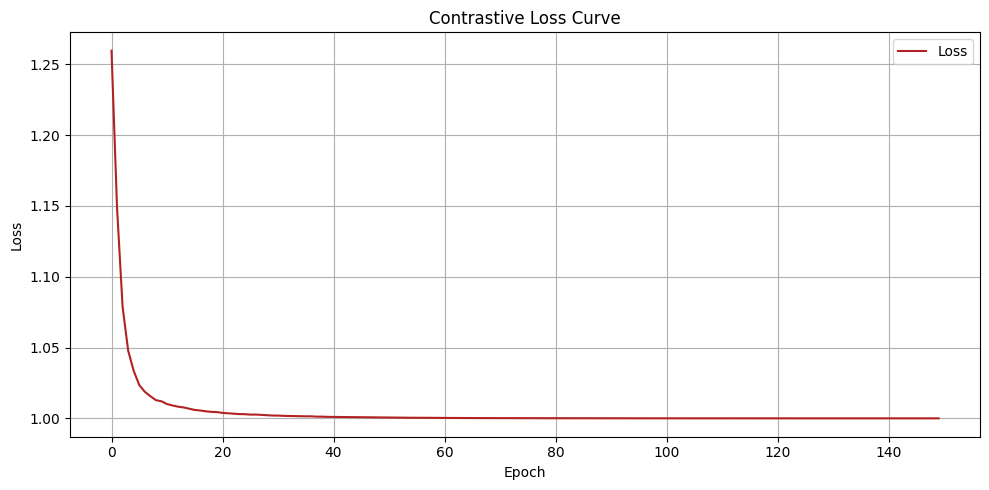

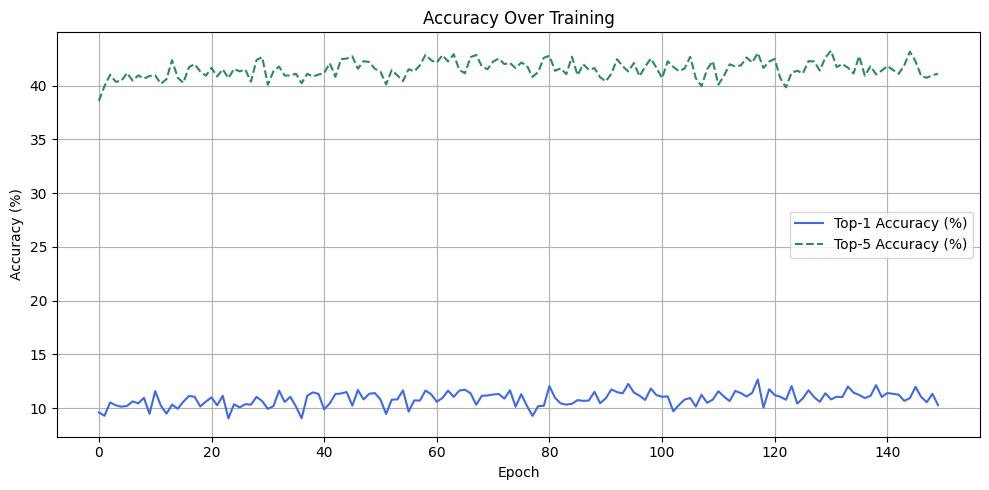

In [89]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

# ✅ Load dataset
dataset = SingleFileEmbeddingPairDataset(
    "C:\\Users\\Z0054udc\\Downloads\\Siamese GNN\\XT_merged_doubled.json"
)
print(f"Found {len(dataset)} dataset entries.")
if len(dataset) == 0:
    raise ValueError("ERROR: No JSON files found!")

# ✅ Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# ✅ Model and optimizer
model = SiameseGNN(in_dim=15, hidden_dim=64, out_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ✅ Training hyperparameters
epochs = 150
grad_accum_steps = 8        # Simulates batch size = 8
loss_history, top1_history, top5_history = [], [], []

# ✅ Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    total_top1 = 0.0
    total_top5 = 0.0
    num_acc = 0
    optimizer.zero_grad()

    for i in tqdm(range(len(dataset)), desc=f"Epoch {epoch+1}"):
        data1, data2, matches = dataset[i]
        data1, data2, matches = data1.to(device), data2.to(device), matches.to(device)

        # Forward pass for this pair
        emb1, emb2 = model(data1, data2)
        loss = triplet_loss(emb1, emb2, matches)
        loss.backward()

        total_loss += loss.item()

        # --- Accuracy tracking
        acc1 = batch_accuracy(emb1, emb2, matches)
        acc5 = batch_topk_accuracy(emb1, emb2, matches, k=5)
        if acc1 is not None and acc5 is not None:
            total_top1 += acc1
            total_top5 += acc5
            num_acc += 1

        # --- Gradient accumulation ---
        if (i + 1) % grad_accum_steps == 0 or (i + 1) == len(dataset):
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            optimizer.step()
            optimizer.zero_grad()

    # ---- Epoch summary ----
    avg_loss = total_loss / len(dataset)
    avg_top1 = (total_top1 / num_acc) * 100 if num_acc > 0 else 0.0
    avg_top5 = (total_top5 / num_acc) * 100 if num_acc > 0 else 0.0

    loss_history.append(avg_loss)
    top1_history.append(avg_top1)
    top5_history.append(avg_top5)

    print(f"Epoch {epoch+1:03d}: Loss = {avg_loss:.4f}, Top-1 = {avg_top1:.2f}%, Top-5 = {avg_top5:.2f}%")

# ✅ Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Loss", color='firebrick')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Contrastive Loss Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Plot accuracy curves
plt.figure(figsize=(10, 5))
plt.plot(top1_history, label="Top-1 Accuracy (%)", color='royalblue')
plt.plot(top5_history, label="Top-5 Accuracy (%)", linestyle="--", color='seagreen')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Over Training")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
torch.save(model.state_dict(), "siamese_gnn.pth")
# To load: model.load_state_dict(torch.load("siamese_gnn.pth"))